# Hypothese 3: Video’s waarvan de comments een positief sentiment hebben, vertonen een significante stijging in het aantal views.

Om te analyseren of het sentiment van comments een invloed heeft op het aantal views, wordt een sentimentanalyse uitgevoerd op de verzamelde comments van elke video. Aangezien de comments in het Nederlands zijn en het aantal beperkt is, wordt gekozen voor een kwalitatieve annotatie door de onderzoeker in plaats van een lexicon-gebaseerde methode.

Elke comment wordt handmatig geclassificeerd als positief, neutraal of negatief op basis van de inhoud en toon van de reactie. Hoewel er geen tweede codeerder beschikbaar is om de betrouwbaarheid van de classificatie te controleren, wordt de consistentie gewaarborgd door het opstellen van duidelijke annotatieregels en het toepassen van een systematische beoordelingsmethode. Daarnaast wordt een deel van de dataset op verschillende tijdstippen gehercodeerd door de onderzoeker om intra-codeurbetrouwbaarheid te verhogen.

Vervolgens wordt een Spearman-correlatieanalyse uitgevoerd tussen het percentage positieve comments en het aantal views, om te onderzoeken of er een verband bestaat tussen comment-sentiment en het bereik van video’s. Daarnaast wordt een beschrijvende analyse uitgevoerd, waarbij het gemiddelde aantal positieve, neutrale en negatieve comments per video wordt vergeleken tussen video’s met en zonder CTA.


## Stap 1: Klaarzetten van de notebook.

In deze stap worden alle nodige libraries ingeladen en klaargezet.<br>
Dit vereenvoudigt het verdere verloop van de notebook.

In [40]:
# Importeer standaard libraries
import nltk
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [26]:
# Importeer zelfgeschreven libraries en reload bij aanpassingen
from lib import helpers
importlib.reload(helpers);

In [27]:
# Importeer de data
videos = pd.read_excel('../output/videos-5y.xlsx')
comments = pd.read_excel('../output/comments-5y.xlsx', index_col=0)
comments.head()

,id,comment_id,parent_comment_id,author,published_at,like_count,comment_nl,is_reply,comment_en
0,KNNAUcLMJpo,Ugzc2tT_j0zGzUcmI-d4AaABAg,NaN,User1,2024-07-30T12:13:39Z,0,Je hebt het helemaal niet nodig😅. Ik heb altij...,False,You don't need it at all😅. I have always had s...
1,xMxDvh30V3U,Ugy8gOtoBda-X6YEJYx4AaABAg,NaN,User2,2021-10-20T19:30:35Z,0,Deze redenering kan je grotendeels kopieren na...,False,You can largely copy this reasoning to having ...
2,xMxDvh30V3U,UgyUSszG7gjw9rNGZoh4AaABAg,NaN,User3,2021-04-08T06:53:16Z,0,I would like to offset if it was just a little...,False,I would like to offset if it was just a little...
3,xMxDvh30V3U,UgzvlwJoLtF1FuEhU0V4AaABAg,NaN,User4,2021-02-19T00:29:56Z,1,Ik heb mij al tientallen jaren afgevraagd waar...,False,I have wondered for decades why holiday trips ...
4,xMxDvh30V3U,UgxYQqlEl_e1lgg8hSF4AaABAg,NaN,User5,2021-02-18T21:34:43Z,0,"Ridiculous idea, how much % does aviation cont...",False,"Ridiculous Idea, How much % Does aviation cont..."


In [28]:
videos.head()

,id,title,publish_date,duration,views,likes,dislikes,shares,comments,engagement,...,comments_2w,comments_1m,comments_2m,comments_3m,engagement_rate_24h,engagement_rate_1w,engagement_rate_2w,engagement_rate_1m,engagement_rate_2m,engagement_rate_3m
0,KNNAUcLMJpo,Veggie 🥕 of vlees 🍖?,2024-07-25T07:35:04Z,0:19,987,12,3,3,1,1.32,...,1,1,1,1.0,1.22,1.46,1.37,1.40,1.30,1.28
1,xMxDvh30V3U,Should flying be prohibited?,2021-02-18T15:00:32Z,14:52,3530,44,8,53,31,3.40,...,10,10,11,11.0,3.90,2.85,2.84,2.75,2.75,2.94
2,KCc98U0fVJ8,Zomerpodcast opnemen op het Nerdland Festival!...,2022-06-22T20:47:49Z,0:21,1011,21,1,1,0,2.08,...,0,0,0,0.0,1.94,1.76,1.65,1.76,2.01,1.86
3,s6zIqrn-3W8,Wij zijn de universiteit van Vlaanderen,2022-12-14T10:21:57Z,1:01,667,13,1,3,0,2.25,...,1,1,1,1.0,4.19,3.29,3.20,3.20,3.18,3.18
4,bl9LxOG4kV8,Zitten we in een financiële bubbel? #WetenSNAP,2022-10-31T15:00:08Z,1:55,1762,28,0,9,1,2.16,...,1,1,1,1.0,3.59,2.67,2.45,2.29,2.25,2.26


In [29]:
nltk.download('vader_lexicon')

# Maak een SentimentIntensityAnalyzer object aan
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tvercamer/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Stap 2: Uitvoeren van de analyses.

In [30]:
# Gebruik VADER op de comment_en om het sentiment te bepalen.
comments['sentiment_score'] = comments['comment_en'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
comments['sentiment_label'] = comments['sentiment_score'].apply(lambda x: 'positief' if x > 0.05 else ('negatief' if x < -0.05 else 'neutraal'))
comments.head()

,id,comment_id,parent_comment_id,author,published_at,like_count,comment_nl,is_reply,comment_en,sentiment_score,sentiment_label
0,KNNAUcLMJpo,Ugzc2tT_j0zGzUcmI-d4AaABAg,NaN,User1,2024-07-30T12:13:39Z,0,Je hebt het helemaal niet nodig😅. Ik heb altij...,False,You don't need it at all😅. I have always had s...,0.7003,positief
1,xMxDvh30V3U,Ugy8gOtoBda-X6YEJYx4AaABAg,NaN,User2,2021-10-20T19:30:35Z,0,Deze redenering kan je grotendeels kopieren na...,False,You can largely copy this reasoning to having ...,0.9808,positief
2,xMxDvh30V3U,UgyUSszG7gjw9rNGZoh4AaABAg,NaN,User3,2021-04-08T06:53:16Z,0,I would like to offset if it was just a little...,False,I would like to offset if it was just a little...,0.8519,positief
3,xMxDvh30V3U,UgzvlwJoLtF1FuEhU0V4AaABAg,NaN,User4,2021-02-19T00:29:56Z,1,Ik heb mij al tientallen jaren afgevraagd waar...,False,I have wondered for decades why holiday trips ...,0.4019,positief
4,xMxDvh30V3U,UgxYQqlEl_e1lgg8hSF4AaABAg,NaN,User5,2021-02-18T21:34:43Z,0,"Ridiculous idea, how much % does aviation cont...",False,"Ridiculous Idea, How much % Does aviation cont...",-0.4329,negatief


In [31]:
# Bereken het percentage positieve comments per video
sentiment_counts = comments.groupby('id')['sentiment_label'].value_counts(normalize=True).unstack().fillna(0).round(4)
sentiment_counts

sentiment_label,negatief,neutraal,positief
id,,,
-2h6bV5jJ-s,0.0000,0.0000,1.0000
-OA1z-_8zgg,0.4423,0.2179,0.3397
-PzrrQ1NDM8,0.0000,0.0000,1.0000
-X8U2pKr5f0,0.0714,0.0714,0.8571
-bjwcYFm6C4,0.1000,0.6000,0.3000
...,...,...,...
zcZ0NdDNEYM,0.0000,0.7500,0.2500
zdNc-wDKvxo,0.3333,0.1667,0.5000
zerifjz7EpM,0.3333,0.0000,0.6667


In [32]:
# Merge sentiment met video data
videos = videos.merge(sentiment_counts, left_on='id', right_index=True)
videos.head()

,id,title,publish_date,duration,views,likes,dislikes,shares,comments,engagement,...,comments_3m,engagement_rate_24h,engagement_rate_1w,engagement_rate_2w,engagement_rate_1m,engagement_rate_2m,engagement_rate_3m,negatief,neutraal,positief
0,KNNAUcLMJpo,Veggie 🥕 of vlees 🍖?,2024-07-25T07:35:04Z,0:19,987,12,3,3,1,1.32,...,1.0,1.22,1.46,1.37,1.40,1.30,1.28,0.0000,0.0000,1.0000
1,xMxDvh30V3U,Should flying be prohibited?,2021-02-18T15:00:32Z,14:52,3530,44,8,53,31,3.40,...,11.0,3.90,2.85,2.84,2.75,2.75,2.94,0.3913,0.1739,0.4348
4,bl9LxOG4kV8,Zitten we in een financiële bubbel? #WetenSNAP,2022-10-31T15:00:08Z,1:55,1762,28,0,9,1,2.16,...,1.0,3.59,2.67,2.45,2.29,2.25,2.26,0.0000,0.0000,1.0000
5,fn1dz5Xez0E,Bestaan bijna - doodervaringen echt?,2024-11-02T13:30:21Z,0:41,846,25,0,4,1,3.55,...,1.0,4.03,4.17,4.04,4.03,3.86,3.78,0.0000,0.0000,1.0000
6,2Uw331k0AdE,Leer je beter wanneer je beweegt?,2024-09-12T14:29:09Z,0:34,1304,38,1,8,1,3.53,...,1.0,3.83,3.77,3.72,3.71,3.59,3.69,0.0000,0.0000,1.0000


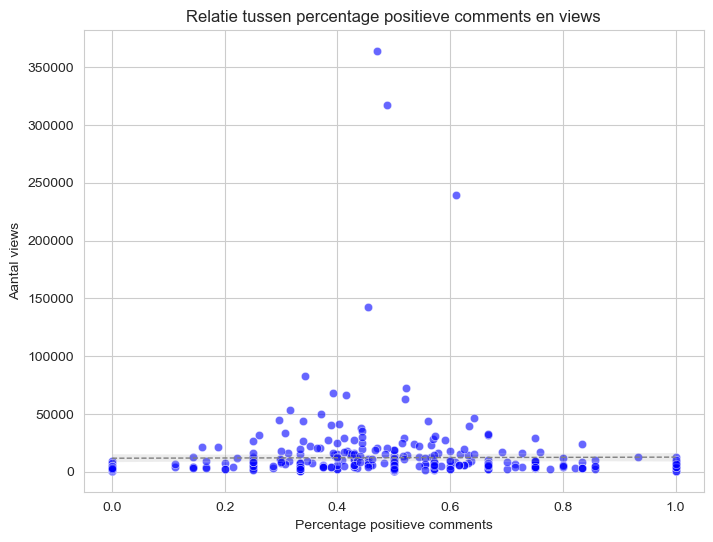

In [33]:
# Scatterplot met regressielijn
plt.figure(figsize=(8, 6))
sns.scatterplot(x=videos['positief'], y=videos['views'], color='blue', alpha=0.6)
sns.regplot(x=videos['positief'], y=videos['views'], scatter=False, color='gray', line_kws={'linestyle': 'dashed', 'linewidth': 1})
plt.title("Relatie tussen percentage positieve comments en views")
plt.xlabel("Percentage positieve comments")
plt.ylabel("Aantal views")
plt.show()

<Axes: xlabel='positief', ylabel='log_views'>

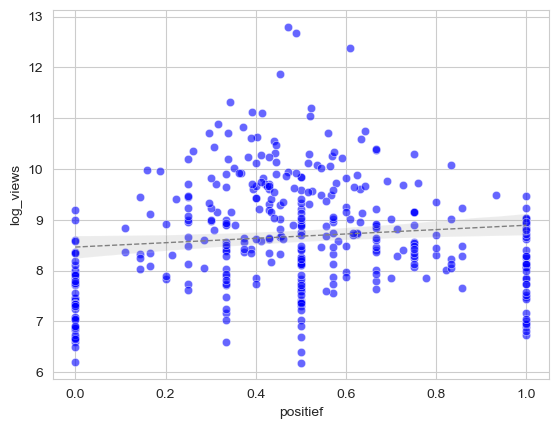

In [35]:
videos['log_views'] = np.log1p(videos['views'])  # Log-transform views
sns.scatterplot(x=videos['positief'], y=videos['log_views'], color='blue', alpha=0.6)
sns.regplot(x=videos['positief'], y=videos['log_views'], scatter=False, color='gray', line_kws={'linestyle': 'dashed', 'linewidth': 1})

In [36]:
# Pearson correlatie
r_value, p_value = stats.pearsonr(videos['positief'], videos['log_views'])

print(f"Pearson correlation coefficient: {r_value:.4f}")
print(f"P-value: {p_value:.4f}")

Pearson correlation coefficient: 0.1100
P-value: 0.0321


In [38]:
# Spearman’s Rangcorrelatie**
correlation, p_value = stats.spearmanr(videos['positief'], videos['views'])
print(f"Spearman correlatie: {correlation}, p-waarde: {p_value}")

Spearman correlatie: 0.0970643093984805, p-waarde: 0.058709301117839674


In [39]:
tau, p_kendall = stats.kendalltau(videos['positief'], videos['log_views'])

print(f"Kendall’s Tau correlation coefficient: {tau:.4f}")
print(f"P-value: {p_kendall:.4f}")

Kendall’s Tau correlation coefficient: 0.0576
P-value: 0.1014


In [41]:
X = videos[['positief']]
X = sm.add_constant(X)  # Adds an intercept
y = videos['log_views']

# Run regression
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_views   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.627
Date:                Tue, 11 Mar 2025   Prob (F-statistic):             0.0321
Time:                        17:34:05   Log-Likelihood:                -574.44
No. Observations:                 380   AIC:                             1153.
Df Residuals:                     378   BIC:                             1161.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4628      0.111     75.981      0.0